In [ ]:
# DATA ENGINEER - Data Collection and Preparation (Google Drive Version)
# This code handles data collection, standardization, and dataset creation in Google Drive

# Install required packages
!pip install icrawler
!pip install pillow
!pip install opencv-python

import os
import shutil
from icrawler.builtin import BingImageCrawler
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import glob
import sys
from google.colab import drive

# Mount Google Drive (creates persistent storage)
drive.mount('/content/drive')

# Define root directory in Google Drive
DRIVE_ROOT = '/content/drive/MyDrive/rose_project'

# Step 1: Data Collection - Collecting Rose Subspecies Images
print("=== DATA COLLECTION ===")

# Define rose subspecies classes (10 classes)
classes = {
    'rosa_rugosa': 600,
    'rosa_gallica': 600,
    'rosa_damascena': 600,
    'rosa_centifolia': 600,
    'rosa_chinensis': 600,
    'rosa_canina': 600,
    'rosa_moschata': 600,
    'rosa_foetida': 600,
    'rosa_multiflora': 600,
    'rosa_glaucescens': 600
}

# Create main directory in Drive
os.makedirs(os.path.join(DRIVE_ROOT, 'rose_dataset/raw_images'), exist_ok=True)

# Crawl images for each rose subspecies
for class_name, count in classes.items():
    save_dir = os.path.join(DRIVE_ROOT, f'rose_dataset/raw_images/{class_name}')
    os.makedirs(save_dir, exist_ok=True)

    print(f"Collecting images for {class_name}...")

    try:
        crawler = BingImageCrawler(storage={'root_dir': save_dir})
        crawler.crawl(keyword=class_name.replace("_", " "), max_num=count)
        print(f"Completed collecting {class_name} images")
    except Exception as e:
        print(f"Error collecting images for {class_name}: {e}")

print("Data collection completed!")

# Step 2: Data Standardization - Clean and standardize images
print("\n=== DATA STANDARDIZATION ===")

def standardize_image(image_path, target_size=(224, 224)):
    """Standardize image by resizing and normalizing"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False

        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(image_path, img_rgb)
        return True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

def clean_and_standardize_dataset():
    """Clean corrupted images and standardize valid ones"""
    any_images_processed = False

    for class_name in classes.keys():
        raw_dir = os.path.join(DRIVE_ROOT, f'rose_dataset/raw_images/{class_name}')
        clean_dir = os.path.join(DRIVE_ROOT, f'rose_dataset/clean_images/{class_name}')
        os.makedirs(clean_dir, exist_ok=True)

        print(f"Processing {class_name}...")
        image_files = glob.glob(os.path.join(raw_dir, '*'))
        valid_count = 0

        for i, image_path in enumerate(image_files):
            if os.path.isfile(image_path) and image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                new_path = os.path.join(clean_dir, f"{class_name}_{valid_count:04d}.jpg")
                shutil.copy2(image_path, new_path)
                if standardize_image(new_path):
                    valid_count += 1
                    any_images_processed = True
                else:
                    try: os.remove(new_path)
                    except: pass

        print(f"Standardized {valid_count} images for {class_name}")
    return any_images_processed

if not clean_and_standardize_dataset():
    print("FATAL ERROR: No valid images found after standardization")
    sys.exit(1)

# Step 3: Dataset Creation - Split into train, validation, test sets
print("\n=== DATASET CREATION ===")

def create_dataset_splits():
    """Split dataset into training, validation, and testing sets"""
    for split in ['train', 'validation', 'test']:
        split_dir = os.path.join(DRIVE_ROOT, f'rose_dataset/{split}')
        os.makedirs(split_dir, exist_ok=True)
        for class_name in classes.keys():
            os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

    for class_name in classes.keys():
        clean_dir = os.path.join(DRIVE_ROOT, f'rose_dataset/clean_images/{class_name}')
        images = glob.glob(os.path.join(clean_dir, '*.jpg'))

        if len(images) < 10:
            print(f"Warning: Only {len(images)} images for {class_name}")
            continue

        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for img_path in train_imgs:
            dest = os.path.join(DRIVE_ROOT, f'rose_dataset/train/{class_name}/{os.path.basename(img_path)}')
            shutil.copy2(img_path, dest)

        for img_path in val_imgs:
            dest = os.path.join(DRIVE_ROOT, f'rose_dataset/validation/{class_name}/{os.path.basename(img_path)}')
            shutil.copy2(img_path, dest)

        for img_path in test_imgs:
            dest = os.path.join(DRIVE_ROOT, f'rose_dataset/test/{class_name}/{os.path.basename(img_path)}')
            shutil.copy2(img_path, dest)

        print(f"{class_name}: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

create_dataset_splits()

# Step 4: Generate dataset summary
print("\n=== DATASET SUMMARY ===")

def generate_dataset_summary():
    """Generate summary of the created dataset"""
    summary = {}
    for split in ['train', 'validation', 'test']:
        summary[split] = {}
        total = 0
        for class_name in classes.keys():
            split_dir = os.path.join(DRIVE_ROOT, f'rose_dataset/{split}/{class_name}')
            count = len(glob.glob(os.path.join(split_dir, '*.jpg')))
            summary[split][class_name] = count
            total += count
        summary[split]['total'] = total

    print("Dataset Summary:")
    print("-" * 50)
    for split, data in summary.items():
        print(f"{split.upper()}:")
        for class_name, count in data.items():
            print(f"  {class_name}: {count}")
        print()
    return summary

dataset_summary = generate_dataset_summary()

# Final verification
print("Data Engineer tasks completed!")
print(f"Dataset saved in Google Drive at: {DRIVE_ROOT}/rose_dataset")
print("Dataset is ready for Data Scientist to use for model training.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== DATA COLLECTION ===
Completed collecting rosa_rugosa images


ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Rosa_gallica_sl56.jpg
ERROR:downloader:Response status code 404, file https://www.rosenschule.de/winaborImport/bilder/thumbnails/354x500fsO/P100022_3.jpg
ERROR:downloader:Response status code 404, file https://www.rosenschule.de/winaborImport/bilder/P100160_2.jpg


Completed collecting rosa_gallica images
Completed collecting rosa_damascena images
Completed collecting rosa_centifolia images
Completed collecting rosa_chinensis images
Completed collecting rosa_canina images
Completed collecting rosa_moschata images
Completed collecting rosa_foetida images


ERROR:downloader:Exception caught when downloading file https://ogden_images.s3.amazonaws.com/www.sungazette.com/images/2025/06/09164217/10telescopeB.jpg, error: HTTPSConnectionPool(host='ogden_images.s3.amazonaws.com', port=443): Max retries exceeded with url: /www.sungazette.com/images/2025/06/09164217/10telescopeB.jpg (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'ogden_images.s3.amazonaws.com'. (_ssl.c:1016)"))), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://ogden_images.s3.amazonaws.com/www.sungazette.com/images/2025/06/09164217/10telescopeB.jpg, error: HTTPSConnectionPool(host='ogden_images.s3.amazonaws.com', port=443): Max retries exceeded with url: /www.sungazette.com/images/2025/06/09164217/10telescopeB.jpg (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mi

Completed collecting rosa_multiflora images


ERROR:downloader:Response status code 403, file https://c.pxhere.com/photos/ab/64/cactus_high_barrel_hires_resolution_hi_res_-453123.jpg
ERROR:downloader:Response status code 403, file https://static.inaturalist.org/photos/226578675/large.jpg


Completed collecting rosa_glaucescens images
Data collection completed!

=== DATA STANDARDIZATION ===
Processing rosa_rugosa...
Standardized 328 images for rosa_rugosa
Processing rosa_gallica...
Standardized 286 images for rosa_gallica
Processing rosa_damascena...
Standardized 318 images for rosa_damascena
Processing rosa_centifolia...
Standardized 301 images for rosa_centifolia
Processing rosa_chinensis...
Standardized 322 images for rosa_chinensis
Processing rosa_canina...
Standardized 345 images for rosa_canina
Processing rosa_moschata...
Standardized 295 images for rosa_moschata
Processing rosa_foetida...
Standardized 268 images for rosa_foetida
Processing rosa_multiflora...
Standardized 367 images for rosa_multiflora
Processing rosa_glaucescens...
Standardized 293 images for rosa_glaucescens

=== DATASET CREATION ===
rosa_rugosa: Train=229, Val=49, Test=50
rosa_gallica: Train=200, Val=43, Test=43
rosa_damascena: Train=222, Val=48, Test=48
rosa_centifolia: Train=210, Val=45, Test=4

In [ ]:
# DATA SCIENTIST - Model Creation and Training (Google Drive Version)
# This code handles neural network model creation, training, and hyperparameter tuning in Google Drive

# Install required packages
!pip install tensorflow
!pip install keras
!pip install scikit-learn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import time
import json
import os
import glob
import sys
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define base directory in Google Drive
DRIVE_ROOT = '/content/drive/MyDrive/rose_project'
MODELS_DIR = os.path.join(DRIVE_ROOT, 'models')
RESULTS_DIR = os.path.join(DRIVE_ROOT, 'results')
DATASET_DIR = os.path.join(DRIVE_ROOT, 'rose_dataset')

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"=== DATA SCIENTIST - MODEL DEVELOPMENT ===")
print(f"Models will be saved to: {MODELS_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")

# Step 0: Validate dataset structure before proceeding
print("\n=== VALIDATING DATASET STRUCTURE ===")

def validate_dataset_structure():
    """Ensure all required directories exist and contain images"""
    required_dirs = ['train', 'validation', 'test']
    missing_dirs = []
    empty_dirs = []

    # Check if base directory exists
    if not os.path.exists(DATASET_DIR):
        print(f"Error: Main dataset directory '{DATASET_DIR}' not found!")
        print("Please run the Data Engineer code first to create the dataset.")
        return False

    # Check each required subdirectory
    for subdir in required_dirs:
        dir_path = os.path.join(DATASET_DIR, subdir)
        if not os.path.exists(dir_path):
            missing_dirs.append(dir_path)
            continue

        # Check if directory has subdirectories (classes)
        class_dirs = [d for d in os.listdir(dir_path)
                     if os.path.isdir(os.path.join(dir_path, d))]

        if not class_dirs:
            empty_dirs.append(dir_path)
            continue

        # Check if classes have images
        for class_dir in class_dirs:
            class_path = os.path.join(dir_path, class_dir)
            images = glob.glob(os.path.join(class_path, '*.jpg'))
            if not images:
                empty_dirs.append(class_path)

    # Report errors
    if missing_dirs:
        print("\nERROR: Missing required directories:")
        for d in missing_dirs:
            print(f"  - {d}")

    if empty_dirs:
        print("\nERROR: Empty directories found:")
        for d in empty_dirs:
            print(f"  - {d}")

    if missing_dirs or empty_dirs:
        print("\nPlease run the Data Engineer code to create the proper dataset structure.")
        return False

    print("Dataset structure validated successfully!")
    return True

# Exit if dataset structure is invalid
if not validate_dataset_structure():
    print("\nFATAL ERROR: Dataset not properly structured.")
    print("Aborting model training.")
    sys.exit(1)

# Step 1: Data Preparation for Training
print("\n=== PREPARING DATA GENERATORS ===")

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 10  # 10 rose subspecies

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation and test data (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'validation'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Count total samples
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

# Step 2: Model Creation Functions
print("\n=== CREATING MODEL ARCHITECTURES ===")

def create_resnet50_model():
    """Create ResNet50 model with transfer learning"""
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

def create_densenet121_model():
    """Create DenseNet121 model with transfer learning"""
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

def create_mobilenetv3_model():
    """Create MobileNetV3Large model with transfer learning"""
    base_model = MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Step 3: Ensure proper data flow
def check_data_generators():
    """Check if data generators are working properly"""
    try:
        # Test the generators
        train_batch = next(train_generator)
        val_batch = next(validation_generator)

        print(f"Train batch - Images shape: {train_batch[0].shape}, Labels shape: {train_batch[1].shape}")
        print(f"Validation batch - Images shape: {val_batch[0].shape}, Labels shape: {val_batch[1].shape}")

        # Check if labels have correct number of classes (10)
        if train_batch[1].shape[1] != NUM_CLASSES:
            print(f"ERROR: Expected {NUM_CLASSES} classes but got {train_batch[1].shape[1]}")
            return False

        # Reset generators
        train_generator.reset()
        validation_generator.reset()

        return True
    except Exception as e:
        print(f"Error with data generators: {e}")
        return False

# Check data generators
if not check_data_generators():
    print("Data generator error! Please check the dataset creation.")
    sys.exit(1)

# Step 4: Training Function
def train_model(model, model_name, epochs=50):
    """Train a model and return training history and metrics"""
    print(f"\n=== TRAINING {model_name.upper()} ===")

    # Print model summary
    print(f"Model parameters: {model.count_params():,}")
    print(f"Number of classes: {NUM_CLASSES}")

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create model-specific directory in Drive
    model_dir = os.path.join(MODELS_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join(model_dir, f'{model_name}_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    # Record training time
    start_time = time.time()

    # Calculate steps per epoch
    steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
    validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    try:
        # Train model
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )

        end_time = time.time()
        training_time = end_time - start_time

        print(f"{model_name} training completed in {training_time/60:.2f} minutes")
        print(f"Model saved to: {model_dir}")

        return history, training_time, model

    except Exception as e:
        print(f"Error during training {model_name}: {e}")
        return None, 0, model

# Step 5: Hyperparameter Tuning (Fine-tuning)
def fine_tune_model(model, model_name, initial_epochs=50):
    """Fine-tune the model by unfreezing some layers"""
    print(f"\n=== FINE-TUNING {model_name.upper()} ===")

    # Unfreeze the base model
    base_model = model.layers[0]
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = len(base_model.layers) // 2

    # Freeze all the layers before fine_tune_at
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0001/10),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
    )

    # Fine-tune
    fine_tune_epochs = 20
    total_epochs = initial_epochs + fine_tune_epochs

    history_fine = model.fit(
        train_generator,
        epochs=total_epochs,
        initial_epoch=initial_epochs,
        validation_data=validation_generator,
        verbose=1
    )

    # Save the fine-tuned model
    model_dir = os.path.join(MODELS_DIR, model_name)
    model.save(os.path.join(model_dir, f'{model_name}_final.h5'))
    print(f"Fine-tuned model saved to: {os.path.join(model_dir, f'{model_name}_final.h5')}")

    return history_fine

# Step 6: Model Evaluation
def evaluate_model(model, model_name):
    """Evaluate model on test set"""
    print(f"\n=== EVALUATING {model_name.upper()} ===")

    try:
        # Calculate test steps
        test_steps = max(1, test_generator.samples // test_generator.batch_size)

        # Evaluate on test set
        test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)
        test_loss = test_results[0]
        test_accuracy = test_results[1]
        test_top3_accuracy = test_results[2]

        # Reset test generator
        test_generator.reset()

        # Get predictions for mAP calculation
        predictions = model.predict(test_generator, steps=test_steps, verbose=1)

        # Reset test generator again
        test_generator.reset()

        # Calculate mAP (simplified as precision for this implementation)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = test_generator.classes[:len(predicted_classes)]  # Match lengths

        # Calculate per-class precision (proxy for mAP)
        from sklearn.metrics import precision_score
        map_score = precision_score(true_classes, predicted_classes, average='macro', zero_division=0)

        return {
            'test_loss': float(test_loss),
            'test_accuracy': float(test_accuracy),
            'test_top3_accuracy': float(test_top3_accuracy),
            'map_score': float(map_score),
            'model_params': int(model.count_params())
        }

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return {
            'test_loss': 0.0,
            'test_accuracy': 0.0,
            'test_top3_accuracy': 0.0,
            'map_score': 0.0,
            'model_params': int(model.count_params())
        }

# Step 7: Train All Models
print("\n=== TRAINING ALL MODELS ===")

models_info = {}

# Model configurations
model_configs = [
    ('ResNet50', create_resnet50_model),
    ('DenseNet121', create_densenet121_model),
    ('MobileNetV3', create_mobilenetv3_model)
]

# Train each model
for model_name, model_creator in model_configs:
    print(f"\n{'='*60}")
    print(f"Processing {model_name}")
    print(f"{'='*60}")

    # Create model
    model = model_creator()

    print(f"{model_name} Model Summary:")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Number of output classes: {NUM_CLASSES}")

    # Train model (initial training)
    history, training_time, trained_model = train_model(model, model_name, epochs=50)

    # Fine-tune the model
    history_fine = fine_tune_model(trained_model, model_name, initial_epochs=50)

    # Evaluate model
    evaluation_results = evaluate_model(trained_model, model_name)

    # Store results
    models_info[model_name] = {
        'training_time': training_time,
        'history': {
            'loss': history.history['loss'],
            'accuracy': history.history['accuracy'],
            'val_loss': history.history['val_loss'],
            'val_accuracy': history.history['val_accuracy']
        },
        'fine_tune_history': {
             'loss': history_fine.history['loss'],
             'accuracy': history_fine.history['accuracy'],
             'val_loss': history_fine.history['val_loss'],
             'val_accuracy': history_fine.history['val_accuracy'],
             'top_3_accuracy': history_fine.history['top_3_accuracy'],
             'val_top_3_accuracy': history_fine.history['val_top_3_accuracy']
        },
        'evaluation': evaluation_results
    }

    print(f"\n{model_name} Results:")
    print(f"Training Time (Initial Phase): {training_time/60:.2f} minutes")
    print(f"Test Accuracy: {evaluation_results['test_accuracy']:.4f}")
    print(f"Test Top-3 Accuracy: {evaluation_results['test_top3_accuracy']:.4f}")
    print(f"mAP Score: {evaluation_results['map_score']:.4f}")
    print(f"Model Parameters: {evaluation_results['model_params']:,}")

# Step 8: Save Training Results to Drive
print("\n=== SAVING RESULTS TO DRIVE ===")

# Save results to JSON file in Drive
results_path = os.path.join(RESULTS_DIR, 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(models_info, f, indent=4)
print(f"Training results saved to: {results_path}")

# Save summary comparison as CSV
summary_data = []
for model_name, info in models_info.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': info['evaluation']['test_accuracy'],
        'Top-3 Acc': info['evaluation']['test_top3_accuracy'],
        'mAP': info['evaluation']['map_score'],
        'Parameters': info['evaluation']['model_params'],
        'Training Time (min)': info['training_time'] / 60
    })

summary_df = pd.DataFrame(summary_data)
summary_path = os.path.join(RESULTS_DIR, 'model_comparison.csv')
summary_df.to_csv(summary_path, index=False)
print(f"Model comparison saved to: {summary_path}")

# Print summary
print("\n=== MODEL COMPARISON SUMMARY ===")
print("-" * 80)
print(f"{'Model':<15} {'Accuracy':<10} {'Top-3 Acc':<12} {'mAP':<8} {'Parameters':<12} {'Time (min)':<12}")
print("-" * 80)

for model_name, info in models_info.items():
    accuracy = info['evaluation']['test_accuracy']
    top3_accuracy = info['evaluation']['test_top3_accuracy']
    map_score = info['evaluation']['map_score']
    params = info['evaluation']['model_params']
    time_min = info['training_time'] / 60
    print(f"{model_name:<15} {accuracy:<10.4f} {top3_accuracy:<12.4f} {map_score:<8.4f} {params:<12,} {time_min:<12.2f}")

print("\nData Scientist tasks completed!")
print(f"All models and results saved to your Google Drive at: {DRIVE_ROOT}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== DATA SCIENTIST - MODEL DEVELOPMENT ===
Models will be saved to: /content/drive/MyDrive/rose_project/models
Results will be saved to: /content/drive/MyDrive/rose_project/results

=== VALIDATING DATASET STRUCTURE ===
Dataset structure validated successfully!

=== PREPARING DATA GENERATORS ===
Found 2675 images belonging to 10 classes.
Found 915 images belonging to 10 classes.
Found 918 images belonging to 10 classes.
Training samples: 2675
Validation samples: 915
Test samples: 918
Class indices: {'rosa_canina': 0, 'rosa_centifolia': 1, 'rosa_chinensis': 2, 'rosa_damascena': 3, 'rosa_foetida': 4, 'rosa_gallica': 5, 'rosa_glaucescens': 6, 'rosa_moschata': 7, 'rosa_multiflora': 8, 'rosa_rugosa': 9}

=== CREATING MODEL ARCHITECTURES ===
Train batch - Images shape: (32, 224, 224, 3), Labels shape: (32, 10)
Validation batch - Images shape: (32, 224, 224, 3), Labe

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.0920 - loss: 2.7333

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.09821, saving model to /content/drive/MyDrive/rose_project/models/ResNet50/ResNet50_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 779ms/step - accuracy: 0.0921 - loss: 2.7311 - val_accuracy: 0.0982 - val_loss: 2.3015 - learning_rate: 0.0010
Epoch 2/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.0625 - loss: 2.3846

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.09821
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.0625 - loss: 2.3846 - val_accuracy: 0.0982 - val_loss: 2.3022 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.1068 - loss: 2.3573
Epoch 3: val_accuracy improved from 0.09821 to 0.15737, saving model to /content/drive/MyDrive/rose_project/models/ResNet50/ResNet50_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 62s 686ms/step - accuracy: 0.1068 - loss: 2.3572 - val_accuracy: 0.1574 - val_loss: 2.2845 - learning_rate: 0.0010
Epoch 4/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.0938 - loss: 2.2997

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.15737
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.0938 - loss: 2.2997 - val_accuracy: 0.1574 - val_loss: 2.2845 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.1194 - loss: 2.3000
Epoch 5: val_accuracy did not improve from 0.15737
83/83 ━━━━━━━━━━━━━━━━━━━━ 71s 664ms/step - accuracy: 0.1194 - loss: 2.3001 - val_accuracy: 0.1172 - val_loss: 2.2894 - learning_rate: 0.0010
Epoch 6/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.0938 - loss: 2.3168

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_accuracy did not improve from 0.15737
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.0938 - loss: 2.3168 - val_accuracy: 0.1161 - val_loss: 2.2900 - learning_rate: 0.0010
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.1173 - loss: 2.3028
Epoch 7: val_accuracy did not improve from 0.15737
83/83 ━━━━━━━━━━━━━━━━━━━━ 74s 623ms/step - accuracy: 0.1172 - loss: 2.3028 - val_accuracy: 0.1574 - val_loss: 2.2841 - learning_rate: 0.0010
Epoch 8/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1875 - loss: 2.3587

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.15737
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.1875 - loss: 2.3587 - val_accuracy: 0.1484 - val_loss: 2.2840 - learning_rate: 0.0010
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.1282 - loss: 2.2966
Epoch 9: val_accuracy improved from 0.15737 to 0.16183, saving model to /content/drive/MyDrive/rose_project/models/ResNet50/ResNet50_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 644ms/step - accuracy: 0.1281 - loss: 2.2966 - val_accuracy: 0.1618 - val_loss: 2.2733 - learning_rate: 0.0010
Epoch 10/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1875 - loss: 2.3062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_accuracy did not improve from 0.16183
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1875 - loss: 2.3062 - val_accuracy: 0.1518 - val_loss: 2.2739 - learning_rate: 0.0010
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.1282 - loss: 2.2983
Epoch 11: val_accuracy did not improve from 0.16183
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 624ms/step - accuracy: 0.1281 - loss: 2.2982 - val_accuracy: 0.1429 - val_loss: 2.2689 - learning_rate: 0.0010
Epoch 12/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.0938 - loss: 2.3595

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_accuracy did not improve from 0.16183
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.0938 - loss: 2.3595 - val_accuracy: 0.1406 - val_loss: 2.2690 - learning_rate: 0.0010
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.1355 - loss: 2.2799
Epoch 13: val_accuracy did not improve from 0.16183
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 994ms/step - accuracy: 0.1354 - loss: 2.2799 - val_accuracy: 0.1429 - val_loss: 2.2699 - learning_rate: 0.0010
Epoch 14/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.1250 - loss: 2.3474

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_accuracy did not improve from 0.16183
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1250 - loss: 2.3474 - val_accuracy: 0.1451 - val_loss: 2.2698 - learning_rate: 0.0010
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.1182 - loss: 2.2897
Epoch 15: val_accuracy improved from 0.16183 to 0.16518, saving model to /content/drive/MyDrive/rose_project/models/ResNet50/ResNet50_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 108s 636ms/step - accuracy: 0.1183 - loss: 2.2897 - val_accuracy: 0.1652 - val_loss: 2.2659 - learning_rate: 0.0010
Epoch 16/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.0625 - loss: 2.3366

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.0625 - loss: 2.3366 - val_accuracy: 0.1607 - val_loss: 2.2667 - learning_rate: 0.0010
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.1373 - loss: 2.2851
Epoch 17: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 622ms/step - accuracy: 0.1372 - loss: 2.2851 - val_accuracy: 0.1484 - val_loss: 2.2701 - learning_rate: 0.0010
Epoch 18/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.1562 - loss: 2.2530

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 18: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.1562 - loss: 2.2530 - val_accuracy: 0.1496 - val_loss: 2.2699 - learning_rate: 0.0010
Epoch 19/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.1260 - loss: 2.2823
Epoch 19: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 77s 626ms/step - accuracy: 0.1260 - loss: 2.2823 - val_accuracy: 0.1362 - val_loss: 2.2665 - learning_rate: 0.0010
Epoch 20/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.1562 - loss: 2.2936

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 20: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1562 - loss: 2.2936 - val_accuracy: 0.1417 - val_loss: 2.2670 - learning_rate: 0.0010
Epoch 21/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.1406 - loss: 2.2837
Epoch 21: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 992ms/step - accuracy: 0.1406 - loss: 2.2836 - val_accuracy: 0.1529 - val_loss: 2.2669 - learning_rate: 2.0000e-04
Epoch 22/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1250 - loss: 2.2757

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 22: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.1250 - loss: 2.2757 - val_accuracy: 0.1518 - val_loss: 2.2669 - learning_rate: 2.0000e-04
Epoch 23/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.1295 - loss: 2.2715
Epoch 23: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 51s 616ms/step - accuracy: 0.1294 - loss: 2.2716 - val_accuracy: 0.1652 - val_loss: 2.2659 - learning_rate: 2.0000e-04
Epoch 24/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1562 - loss: 2.2569

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 24: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1562 - loss: 2.2569 - val_accuracy: 0.1652 - val_loss: 2.2658 - learning_rate: 2.0000e-04
Epoch 25/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.1313 - loss: 2.2754
Epoch 25: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 631ms/step - accuracy: 0.1313 - loss: 2.2755 - val_accuracy: 0.1629 - val_loss: 2.2646 - learning_rate: 2.0000e-04
Epoch 26/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.0938 - loss: 2.2880

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 26: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.0938 - loss: 2.2880 - val_accuracy: 0.1641 - val_loss: 2.2646 - learning_rate: 2.0000e-04
Epoch 27/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.1227 - loss: 2.2786
Epoch 27: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 991ms/step - accuracy: 0.1228 - loss: 2.2786 - val_accuracy: 0.1585 - val_loss: 2.2667 - learning_rate: 2.0000e-04
Epoch 28/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.0938 - loss: 2.2893

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 28: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.0938 - loss: 2.2893 - val_accuracy: 0.1585 - val_loss: 2.2667 - learning_rate: 2.0000e-04
Epoch 29/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.1342 - loss: 2.2653
Epoch 29: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 986ms/step - accuracy: 0.1341 - loss: 2.2653 - val_accuracy: 0.1596 - val_loss: 2.2674 - learning_rate: 2.0000e-04
Epoch 30/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1875 - loss: 2.2432

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 30: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 30: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1875 - loss: 2.2432 - val_accuracy: 0.1574 - val_loss: 2.2675 - learning_rate: 2.0000e-04
Epoch 31/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.1252 - loss: 2.2701
Epoch 31: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 999ms/step - accuracy: 0.1252 - loss: 2.2702 - val_accuracy: 0.1574 - val_loss: 2.2668 - learning_rate: 4.0000e-05
Epoch 32/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.1250 - loss: 2.2465

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 32: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.1250 - loss: 2.2465 - val_accuracy: 0.1574 - val_loss: 2.2668 - learning_rate: 4.0000e-05
Epoch 33/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.1214 - loss: 2.2719
Epoch 33: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.1215 - loss: 2.2719 - val_accuracy: 0.1562 - val_loss: 2.2666 - learning_rate: 4.0000e-05
Epoch 34/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.0938 - loss: 2.3754

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 34: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.0938 - loss: 2.3754 - val_accuracy: 0.1562 - val_loss: 2.2666 - learning_rate: 4.0000e-05
Epoch 35/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.1340 - loss: 2.2780
Epoch 35: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 35: val_accuracy did not improve from 0.16518
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.1339 - loss: 2.2780 - val_accuracy: 0.1596 - val_loss: 2.2658 - learning_rate: 4.0000e-05
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 25.
ResNet50 training completed in 26.33 minutes
Model saved to: /content/drive/MyDrive/rose_project/models/ResNet50

=== FINE-TUNING RESNET50 ===
Epoch 51/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 110s 860ms/step - accuracy: 0.1150 - loss: 3.0394 - top_3_accuracy: 0.3170 - val_accuracy: 0.1224 - val_loss: 2.5460 - val_top_3_accuracy: 0.2918
Epoch 52/70
84/84 ━━━━━━━━━━━

Fine-tuned model saved to: /content/drive/MyDrive/rose_project/models/ResNet50/ResNet50_final.h5

=== EVALUATING RESNET50 ===


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.4252 - loss: 1.6869 - top_3_accuracy: 0.7368
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step

ResNet50 Results:
Training Time (Initial Phase): 26.33 minutes
Test Accuracy: 0.4174
Test Top-3 Accuracy: 0.7254
mAP Score: 0.4532
Model Parameters: 24,641,930

Processing DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DenseNet121 Model Summary:
Total parameters: 7,567,434
Number of output classes: 10

=== TRAINING DENSENET121 ===
Model parameters: 7,567,434
Number of classes: 10
Steps per epoch: 83
Validation steps: 28
Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.1917 - loss: 2.5791
Epoch 1: val_accuracy improved from -inf to 0.45982, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 107s 925ms/step - accuracy: 0.1923 - loss: 2.5755 - val_accuracy: 0.4598 - val_loss: 1.6053 - learning_rate: 0.0010
Epoch 2/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4062 - loss: 1.6051

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.45982 to 0.47879, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.4062 - loss: 1.6051 - val_accuracy: 0.4788 - val_loss: 1.5903 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.3382 - loss: 1.8589
Epoch 3: val_accuracy improved from 0.47879 to 0.51116, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 999ms/step - accuracy: 0.3382 - loss: 1.8590 - val_accuracy: 0.5112 - val_loss: 1.4928 - learning_rate: 0.0010
Epoch 4/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.1875 - loss: 2.1983

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.51116
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1875 - loss: 2.1983 - val_accuracy: 0.5100 - val_loss: 1.4914 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.3618 - loss: 1.7953
Epoch 5: val_accuracy improved from 0.51116 to 0.52902, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 109s 654ms/step - accuracy: 0.3620 - loss: 1.7951 - val_accuracy: 0.5290 - val_loss: 1.3920 - learning_rate: 0.0010
Epoch 6/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.5625 - loss: 1.5095

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_accuracy did not improve from 0.52902
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5625 - loss: 1.5095 - val_accuracy: 0.5279 - val_loss: 1.3907 - learning_rate: 0.0010
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.4043 - loss: 1.6937
Epoch 7: val_accuracy improved from 0.52902 to 0.55469, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 77s 637ms/step - accuracy: 0.4044 - loss: 1.6936 - val_accuracy: 0.5547 - val_loss: 1.3366 - learning_rate: 0.0010
Epoch 8/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.2812 - loss: 1.7352

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.55469
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.2812 - loss: 1.7352 - val_accuracy: 0.5513 - val_loss: 1.3338 - learning_rate: 0.0010
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.4174 - loss: 1.6713
Epoch 9: val_accuracy improved from 0.55469 to 0.58817, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 648ms/step - accuracy: 0.4176 - loss: 1.6710 - val_accuracy: 0.5882 - val_loss: 1.2977 - learning_rate: 0.0010
Epoch 10/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.5000 - loss: 1.5939

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_accuracy improved from 0.58817 to 0.59487, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5000 - loss: 1.5939 - val_accuracy: 0.5949 - val_loss: 1.2954 - learning_rate: 0.0010
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.4260 - loss: 1.6506
Epoch 11: val_accuracy did not improve from 0.59487
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 637ms/step - accuracy: 0.4260 - loss: 1.6503 - val_accuracy: 0.5848 - val_loss: 1.2573 - learning_rate: 0.0010
Epoch 12/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4688 - loss: 1.7112

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_accuracy did not improve from 0.59487
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4688 - loss: 1.7112 - val_accuracy: 0.5904 - val_loss: 1.2582 - learning_rate: 0.0010
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.4688 - loss: 1.5338
Epoch 13: val_accuracy did not improve from 0.59487
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 690ms/step - accuracy: 0.4685 - loss: 1.5343 - val_accuracy: 0.5938 - val_loss: 1.2516 - learning_rate: 0.0010
Epoch 14/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4375 - loss: 1.4023

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_accuracy did not improve from 0.59487
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4375 - loss: 1.4023 - val_accuracy: 0.5915 - val_loss: 1.2542 - learning_rate: 0.0010
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.4558 - loss: 1.5376
Epoch 15: val_accuracy improved from 0.59487 to 0.61496, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4557 - loss: 1.5376 - val_accuracy: 0.6150 - val_loss: 1.2515 - learning_rate: 0.0010
Epoch 16/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.4688 - loss: 1.6499

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_accuracy did not improve from 0.61496
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.4688 - loss: 1.6499 - val_accuracy: 0.6116 - val_loss: 1.2530 - learning_rate: 0.0010
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4835 - loss: 1.5351
Epoch 17: val_accuracy did not improve from 0.61496
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 983ms/step - accuracy: 0.4834 - loss: 1.5352 - val_accuracy: 0.5815 - val_loss: 1.2552 - learning_rate: 0.0010
Epoch 18/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4688 - loss: 1.7117

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 18: val_accuracy did not improve from 0.61496
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4688 - loss: 1.7117 - val_accuracy: 0.5681 - val_loss: 1.2606 - learning_rate: 0.0010
Epoch 19/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.4737 - loss: 1.4500
Epoch 19: val_accuracy improved from 0.61496 to 0.61719, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 110s 634ms/step - accuracy: 0.4736 - loss: 1.4504 - val_accuracy: 0.6172 - val_loss: 1.2134 - learning_rate: 2.0000e-04
Epoch 20/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.5312 - loss: 1.5843

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 20: val_accuracy improved from 0.61719 to 0.61830, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5312 - loss: 1.5843 - val_accuracy: 0.6183 - val_loss: 1.2124 - learning_rate: 2.0000e-04
Epoch 21/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.4824 - loss: 1.4744
Epoch 21: val_accuracy improved from 0.61830 to 0.63058, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 622ms/step - accuracy: 0.4825 - loss: 1.4743 - val_accuracy: 0.6306 - val_loss: 1.1790 - learning_rate: 2.0000e-04
Epoch 22/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6562 - loss: 1.1642

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 22: val_accuracy improved from 0.63058 to 0.63281, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6562 - loss: 1.1642 - val_accuracy: 0.6328 - val_loss: 1.1786 - learning_rate: 2.0000e-04
Epoch 23/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.5039 - loss: 1.4247
Epoch 23: val_accuracy improved from 0.63281 to 0.63839, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 77s 626ms/step - accuracy: 0.5037 - loss: 1.4251 - val_accuracy: 0.6384 - val_loss: 1.1633 - learning_rate: 2.0000e-04
Epoch 24/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5000 - loss: 1.4923

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 24: val_accuracy improved from 0.63839 to 0.63951, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5000 - loss: 1.4923 - val_accuracy: 0.6395 - val_loss: 1.1629 - learning_rate: 2.0000e-04
Epoch 25/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.5054 - loss: 1.4331
Epoch 25: val_accuracy did not improve from 0.63951
83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 619ms/step - accuracy: 0.5054 - loss: 1.4331 - val_accuracy: 0.6317 - val_loss: 1.1546 - learning_rate: 2.0000e-04
Epoch 26/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5312 - loss: 1.4602

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 26: val_accuracy did not improve from 0.63951
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5312 - loss: 1.4602 - val_accuracy: 0.6339 - val_loss: 1.1542 - learning_rate: 2.0000e-04
Epoch 27/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5036 - loss: 1.4156
Epoch 27: val_accuracy did not improve from 0.63951
83/83 ━━━━━━━━━━━━━━━━━━━━ 78s 610ms/step - accuracy: 0.5035 - loss: 1.4156 - val_accuracy: 0.6283 - val_loss: 1.1551 - learning_rate: 2.0000e-04
Epoch 28/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.4062 - loss: 1.6067

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 28: val_accuracy did not improve from 0.63951
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.4062 - loss: 1.6067 - val_accuracy: 0.6272 - val_loss: 1.1557 - learning_rate: 2.0000e-04
Epoch 29/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.4972 - loss: 1.4082
Epoch 29: val_accuracy improved from 0.63951 to 0.64286, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4973 - loss: 1.4081 - val_accuracy: 0.6429 - val_loss: 1.1388 - learning_rate: 2.0000e-04
Epoch 30/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5000 - loss: 1.7984

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 30: val_accuracy improved from 0.64286 to 0.64397, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5000 - loss: 1.7984 - val_accuracy: 0.6440 - val_loss: 1.1384 - learning_rate: 2.0000e-04
Epoch 31/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4994 - loss: 1.4176
Epoch 31: val_accuracy improved from 0.64397 to 0.64955, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 991ms/step - accuracy: 0.4994 - loss: 1.4175 - val_accuracy: 0.6496 - val_loss: 1.1310 - learning_rate: 2.0000e-04
Epoch 32/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4688 - loss: 1.5658

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 32: val_accuracy improved from 0.64955 to 0.65067, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4688 - loss: 1.5658 - val_accuracy: 0.6507 - val_loss: 1.1306 - learning_rate: 2.0000e-04
Epoch 33/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.4804 - loss: 1.4721
Epoch 33: val_accuracy did not improve from 0.65067
83/83 ━━━━━━━━━━━━━━━━━━━━ 107s 623ms/step - accuracy: 0.4806 - loss: 1.4715 - val_accuracy: 0.6473 - val_loss: 1.1326 - learning_rate: 2.0000e-04
Epoch 34/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4688 - loss: 1.6856

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 34: val_accuracy did not improve from 0.65067
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4688 - loss: 1.6856 - val_accuracy: 0.6484 - val_loss: 1.1327 - learning_rate: 2.0000e-04
Epoch 35/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.5146 - loss: 1.3874
Epoch 35: val_accuracy did not improve from 0.65067
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 675ms/step - accuracy: 0.5145 - loss: 1.3876 - val_accuracy: 0.6473 - val_loss: 1.1213 - learning_rate: 2.0000e-04
Epoch 36/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4062 - loss: 1.4769

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 36: val_accuracy did not improve from 0.65067
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4062 - loss: 1.4769 - val_accuracy: 0.6496 - val_loss: 1.1208 - learning_rate: 2.0000e-04
Epoch 37/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.5078 - loss: 1.3990
Epoch 37: val_accuracy improved from 0.65067 to 0.65290, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 641ms/step - accuracy: 0.5079 - loss: 1.3989 - val_accuracy: 0.6529 - val_loss: 1.1144 - learning_rate: 2.0000e-04
Epoch 38/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.4688 - loss: 1.4931

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 38: val_accuracy improved from 0.65290 to 0.65513, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.4688 - loss: 1.4931 - val_accuracy: 0.6551 - val_loss: 1.1139 - learning_rate: 2.0000e-04
Epoch 39/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.5114 - loss: 1.3902
Epoch 39: val_accuracy did not improve from 0.65513
83/83 ━━━━━━━━━━━━━━━━━━━━ 52s 624ms/step - accuracy: 0.5114 - loss: 1.3902 - val_accuracy: 0.6451 - val_loss: 1.1068 - learning_rate: 2.0000e-04
Epoch 40/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.4062 - loss: 1.3579

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 40: val_accuracy did not improve from 0.65513
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4062 - loss: 1.3579 - val_accuracy: 0.6451 - val_loss: 1.1072 - learning_rate: 2.0000e-04
Epoch 41/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5210 - loss: 1.3822
Epoch 41: val_accuracy improved from 0.65513 to 0.65737, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5208 - loss: 1.3824 - val_accuracy: 0.6574 - val_loss: 1.1036 - learning_rate: 2.0000e-04
Epoch 42/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.5625 - loss: 1.1160

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 42: val_accuracy did not improve from 0.65737
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5625 - loss: 1.1160 - val_accuracy: 0.6562 - val_loss: 1.1043 - learning_rate: 2.0000e-04
Epoch 43/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5056 - loss: 1.3998
Epoch 43: val_accuracy improved from 0.65737 to 0.65960, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5057 - loss: 1.3998 - val_accuracy: 0.6596 - val_loss: 1.1121 - learning_rate: 2.0000e-04
Epoch 44/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.3750 - loss: 1.5951

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 44: val_accuracy did not improve from 0.65960
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3750 - loss: 1.5951 - val_accuracy: 0.6562 - val_loss: 1.1114 - learning_rate: 2.0000e-04
Epoch 45/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5140 - loss: 1.3786
Epoch 45: val_accuracy did not improve from 0.65960
83/83 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5141 - loss: 1.3786 - val_accuracy: 0.6574 - val_loss: 1.1062 - learning_rate: 2.0000e-04
Epoch 46/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.4375 - loss: 1.4278

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 46: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 46: val_accuracy did not improve from 0.65960
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4375 - loss: 1.4278 - val_accuracy: 0.6574 - val_loss: 1.1058 - learning_rate: 2.0000e-04
Epoch 47/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.5259 - loss: 1.3529
Epoch 47: val_accuracy improved from 0.65960 to 0.66295, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.5260 - loss: 1.3531 - val_accuracy: 0.6629 - val_loss: 1.0944 - learning_rate: 4.0000e-05
Epoch 48/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.6250 - loss: 1.3485

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 48: val_accuracy did not improve from 0.66295
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6250 - loss: 1.3485 - val_accuracy: 0.6629 - val_loss: 1.0943 - learning_rate: 4.0000e-05
Epoch 49/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5112 - loss: 1.3569
Epoch 49: val_accuracy improved from 0.66295 to 0.66518, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 691ms/step - accuracy: 0.5113 - loss: 1.3570 - val_accuracy: 0.6652 - val_loss: 1.0878 - learning_rate: 4.0000e-05
Epoch 50/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.6250 - loss: 1.0719

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 50: val_accuracy improved from 0.66518 to 0.66629, saving model to /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.6250 - loss: 1.0719 - val_accuracy: 0.6663 - val_loss: 1.0879 - learning_rate: 4.0000e-05
Restoring model weights from the end of the best epoch: 49.
DenseNet121 training completed in 37.24 minutes
Model saved to: /content/drive/MyDrive/rose_project/models/DenseNet121

=== FINE-TUNING DENSENET121 ===
Epoch 51/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.3722 - loss: 1.8396 - top_3_accuracy: 0.6854 - val_accuracy: 0.6164 - val_loss: 1.1611 - val_top_3_accuracy: 0.8918
Epoch 52/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 626ms/step - accuracy: 0.4379 - loss: 1.6697 - top_3_accuracy: 0.7368 - val_accuracy: 0.6022 - val_loss: 1.2043 - val_top_3_accuracy: 0.8710
Epoch 53/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 623ms/step - accuracy: 0.4437 - loss: 1.5934 - top_3_accuracy: 0.7592 - val_accuracy: 0.6098 - val_loss: 1.1935 - val_top_3_accuracy: 0.8710
Epoch 54/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 626ms/step - accuracy: 0.4647 - loss: 1.5266 - top_

Fine-tuned model saved to: /content/drive/MyDrive/rose_project/models/DenseNet121/DenseNet121_final.h5

=== EVALUATING DENSENET121 ===
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7300 - loss: 0.8441 - top_3_accuracy: 0.9171
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step

DenseNet121 Results:
Training Time (Initial Phase): 37.24 minutes
Test Accuracy: 0.7243
Test Top-3 Accuracy: 0.9129
mAP Score: 0.7336
Model Parameters: 7,567,434

Processing MobileNetV3
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV3 Model Summary:
Total parameters: 3,493,514
Number of output classes: 10

=== TRAINING MOBILENETV3 ===
Model parameters: 3,493,514
Number of classes: 10
Steps per epoch: 83
Validation steps: 28
Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.1162 - loss: 2.5009
Epoch 1: val_accuracy improved from -inf to 0.13839, saving model to /content/drive/MyDrive/rose_project/models/MobileNetV3/MobileNetV3_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 76s 752ms/step - accuracy: 0.1161 - loss: 2.5005 - val_accuracy: 0.1384 - val_loss: 2.2763 - learning_rate: 0.0010
Epoch 2/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1562 - loss: 2.3321

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.13839
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1562 - loss: 2.3321 - val_accuracy: 0.1328 - val_loss: 2.2768 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.0989 - loss: 2.4012
Epoch 3: val_accuracy improved from 0.13839 to 0.17188, saving model to /content/drive/MyDrive/rose_project/models/MobileNetV3/MobileNetV3_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 898ms/step - accuracy: 0.0990 - loss: 2.4010 - val_accuracy: 0.1719 - val_loss: 2.2851 - learning_rate: 0.0010
Epoch 4/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1250 - loss: 2.3769

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1250 - loss: 2.3769 - val_accuracy: 0.1719 - val_loss: 2.2849 - learning_rate: 0.0010
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.1331 - loss: 2.3340
Epoch 5: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 937ms/step - accuracy: 0.1330 - loss: 2.3340 - val_accuracy: 0.1429 - val_loss: 2.2843 - learning_rate: 0.0010
Epoch 6/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1562 - loss: 2.2446

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.1562 - loss: 2.2446 - val_accuracy: 0.1451 - val_loss: 2.2847 - learning_rate: 0.0010
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.1183 - loss: 2.3338
Epoch 7: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 594ms/step - accuracy: 0.1183 - loss: 2.3337 - val_accuracy: 0.1562 - val_loss: 2.2749 - learning_rate: 2.0000e-04
Epoch 8/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0938 - loss: 2.3249

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.0938 - loss: 2.3249 - val_accuracy: 0.1551 - val_loss: 2.2747 - learning_rate: 2.0000e-04
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.1207 - loss: 2.3098
Epoch 9: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 611ms/step - accuracy: 0.1207 - loss: 2.3098 - val_accuracy: 0.1350 - val_loss: 2.2805 - learning_rate: 2.0000e-04
Epoch 10/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.1250 - loss: 2.3004

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1250 - loss: 2.3004 - val_accuracy: 0.1373 - val_loss: 2.2804 - learning_rate: 2.0000e-04
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.1228 - loss: 2.2965
Epoch 11: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 78s 610ms/step - accuracy: 0.1228 - loss: 2.2965 - val_accuracy: 0.1161 - val_loss: 2.2781 - learning_rate: 2.0000e-04
Epoch 12/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1562 - loss: 2.2755

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 12: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.1562 - loss: 2.2755 - val_accuracy: 0.1150 - val_loss: 2.2780 - learning_rate: 2.0000e-04
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.1172 - loss: 2.3019
Epoch 13: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 13: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 657ms/step - accuracy: 0.1172 - loss: 2.3020 - val_accuracy: 0.1663 - val_loss: 2.2753 - learning_rate: 2.0000e-04
Epoch 14/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0938 - loss: 2.3628

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 14: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.0938 - loss: 2.3628 - val_accuracy: 0.1663 - val_loss: 2.2753 - learning_rate: 4.0000e-05
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.1164 - loss: 2.3007
Epoch 15: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 701ms/step - accuracy: 0.1165 - loss: 2.3007 - val_accuracy: 0.1641 - val_loss: 2.2758 - learning_rate: 4.0000e-05
Epoch 16/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.1250 - loss: 2.3220

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 16: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.1250 - loss: 2.3220 - val_accuracy: 0.1663 - val_loss: 2.2757 - learning_rate: 4.0000e-05
Epoch 17/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.1272 - loss: 2.2924
Epoch 17: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 49s 595ms/step - accuracy: 0.1272 - loss: 2.2925 - val_accuracy: 0.1618 - val_loss: 2.2754 - learning_rate: 4.0000e-05
Epoch 18/50
 1/83 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.1250 - loss: 2.3088

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 18: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 18: val_accuracy did not improve from 0.17188
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1250 - loss: 2.3088 - val_accuracy: 0.1629 - val_loss: 2.2755 - learning_rate: 4.0000e-05
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
MobileNetV3 training completed in 11.66 minutes
Model saved to: /content/drive/MyDrive/rose_project/models/MobileNetV3

=== FINE-TUNING MOBILENETV3 ===
Epoch 51/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 109s 884ms/step - accuracy: 0.1031 - loss: 4.4969 - top_3_accuracy: 0.2806 - val_accuracy: 0.1508 - val_loss: 2.2774 - val_top_3_accuracy: 0.3803
Epoch 52/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 614ms/step - accuracy: 0.0963 - loss: 2.9034 - top_3_accuracy: 0.2911 - val_accuracy: 0.1344 - val_loss: 2.2790 - val_top_3_accuracy: 0.3530
Epoch 53/70
84/84 ━━━━━━━━━━━━━━━━━━━━ 52s 615ms/step - accuracy: 0.1095 - loss: 2.5622 - top_3_accuracy: 0.3258 - val_a

Fine-tuned model saved to: /content/drive/MyDrive/rose_project/models/MobileNetV3/MobileNetV3_final.h5

=== EVALUATING MOBILENETV3 ===
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.1259 - loss: 2.3277 - top_3_accuracy: 0.2759
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step

MobileNetV3 Results:
Training Time (Initial Phase): 11.66 minutes
Test Accuracy: 0.1038
Test Top-3 Accuracy: 0.3259
mAP Score: 0.2349
Model Parameters: 3,493,514

=== SAVING RESULTS TO DRIVE ===
Training results saved to: /content/drive/MyDrive/rose_project/results/training_results.json
Model comparison saved to: /content/drive/MyDrive/rose_project/results/model_comparison.csv

=== MODEL COMPARISON SUMMARY ===
--------------------------------------------------------------------------------
Model           Accuracy   Top-3 Acc    mAP      Parameters   Time (min)  
--------------------------------------------------------------------------------
ResNet50        0.4174     0.7254       0.4532   24,641,930   26.33     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== DATA ANALYST - VISUALIZATION AND ANALYSIS ===
Visualizations will be saved to: /content/drive/MyDrive/rose_project/visualizations

=== LOADING TRAINING RESULTS ===
Training results loaded successfully from: /content/drive/MyDrive/rose_project/results/training_results.json

=== DATASET VISUALIZATION ===
Saved dataset visualization to: /content/drive/MyDrive/rose_project/visualizations/dataset_distribution.png


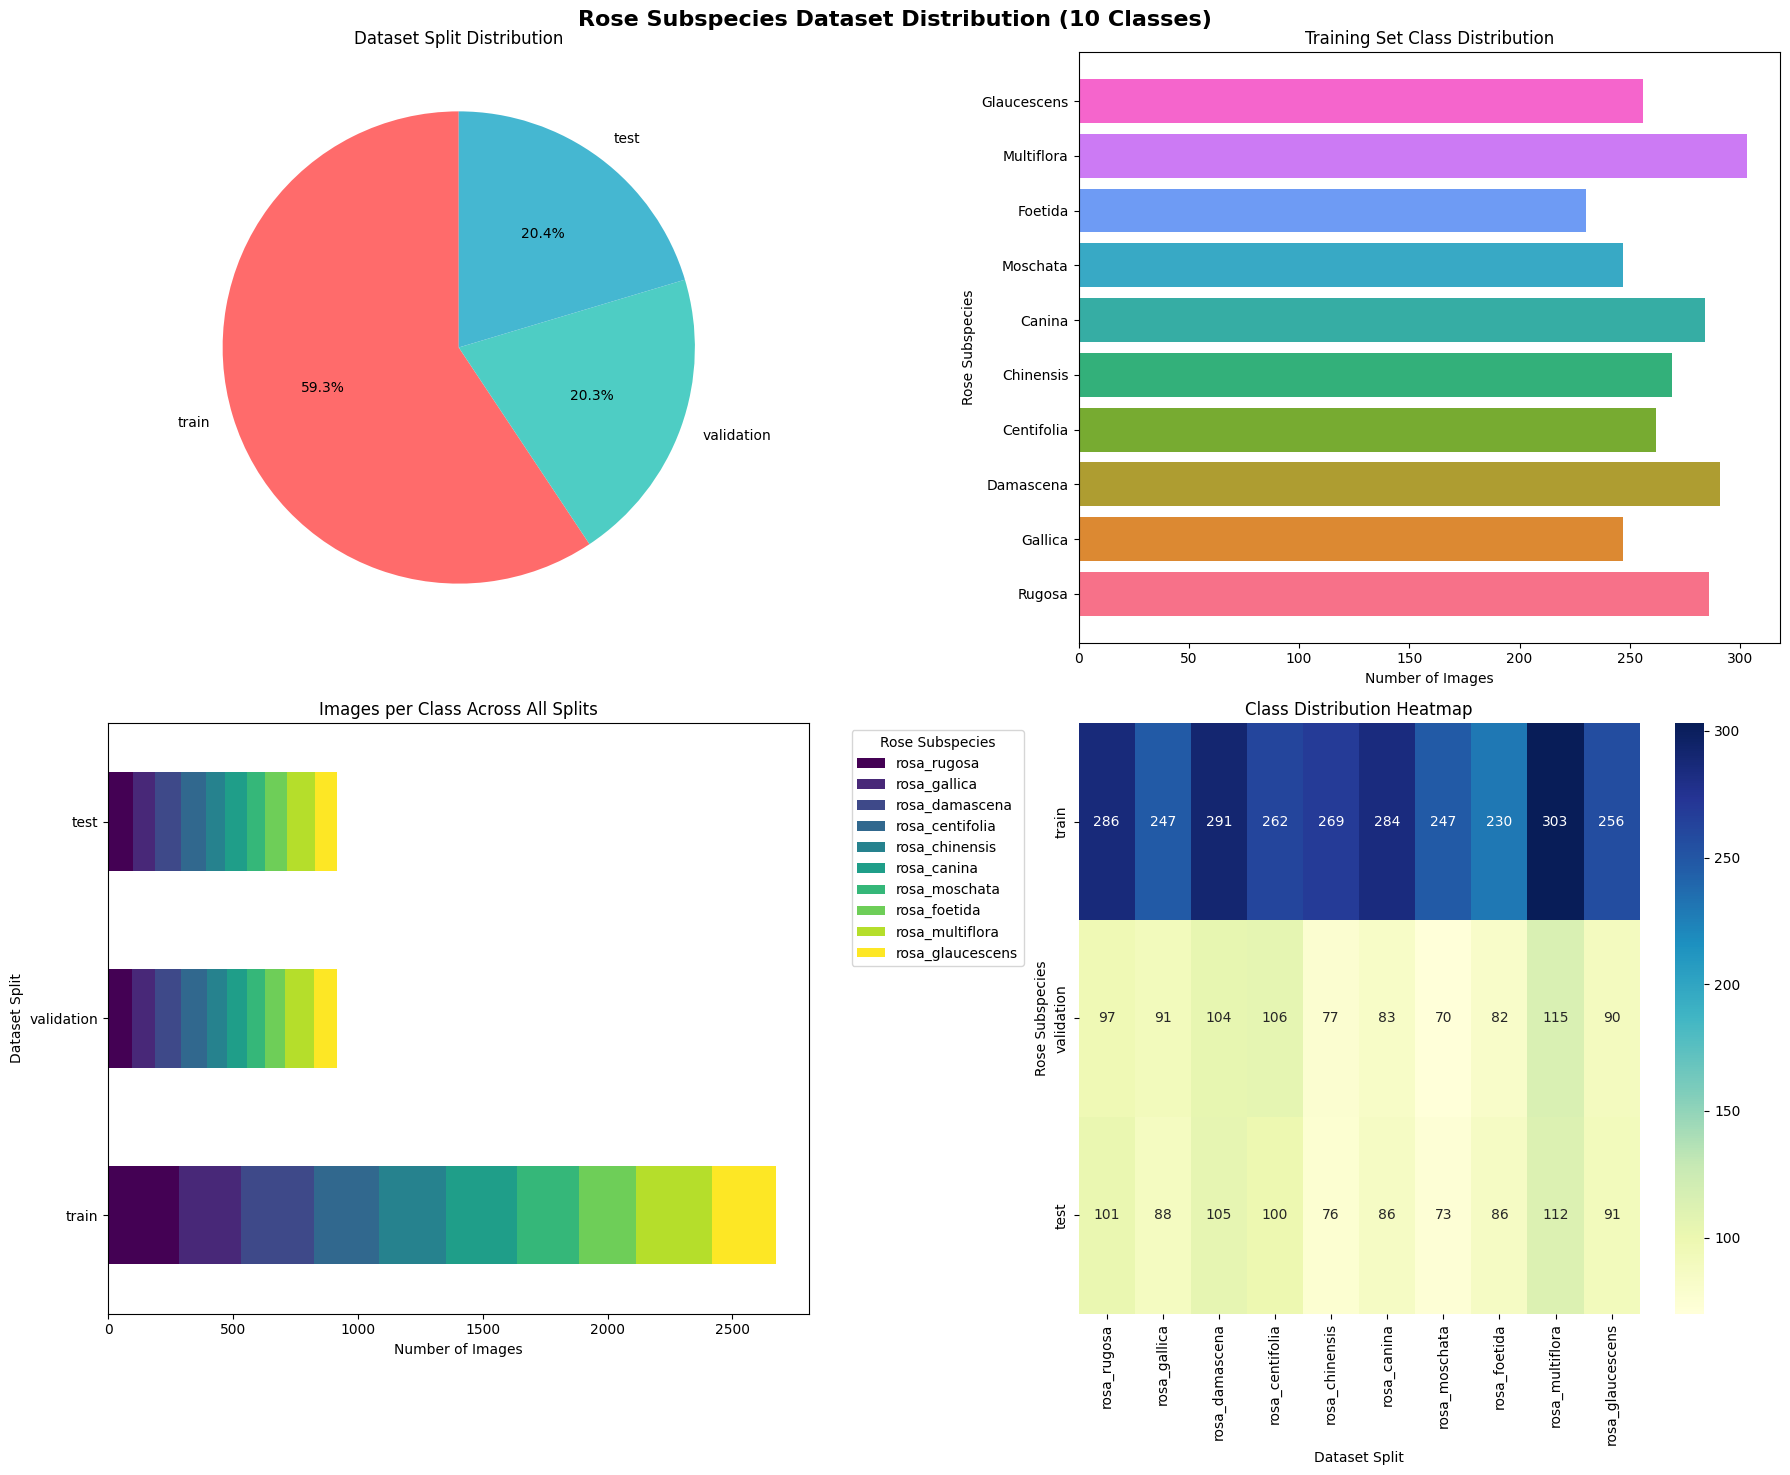


=== TRAINING PERFORMANCE VISUALIZATION ===
Saved training history for ResNet50 to: /content/drive/MyDrive/rose_project/visualizations/training_history_ResNet50.png


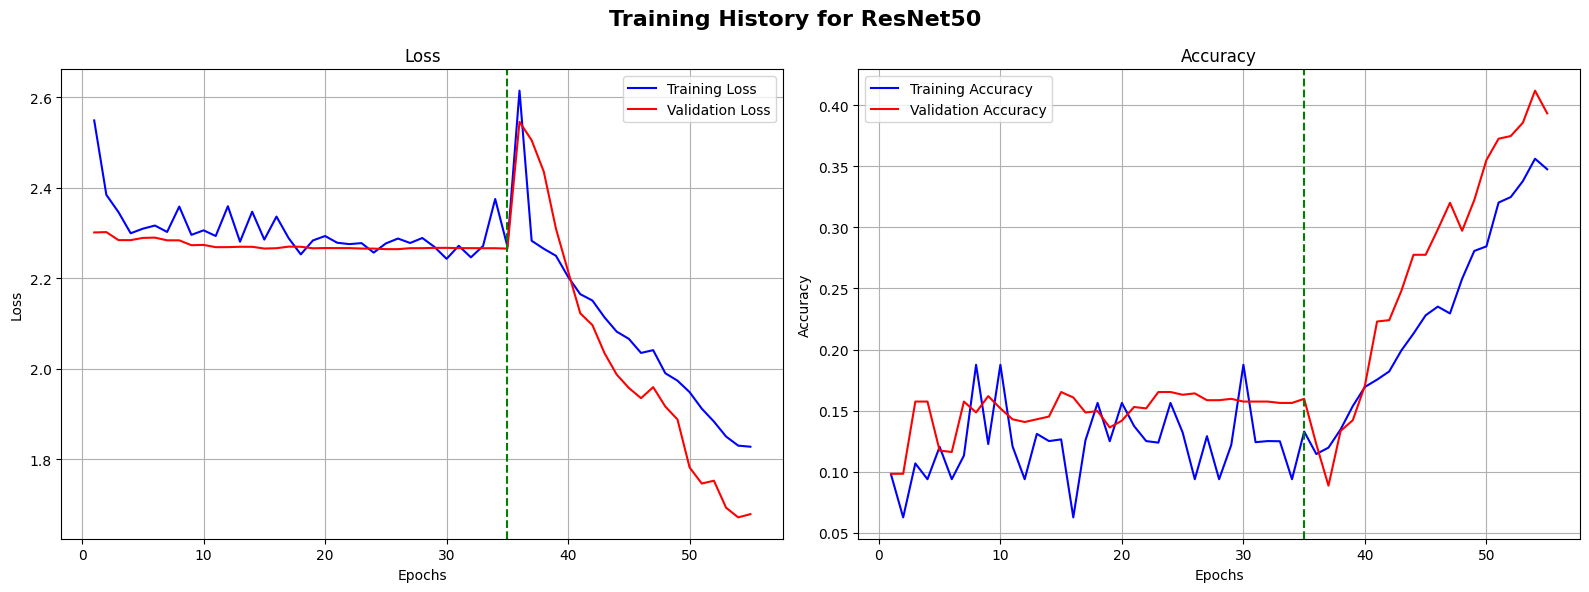

Saved training history for DenseNet121 to: /content/drive/MyDrive/rose_project/visualizations/training_history_DenseNet121.png


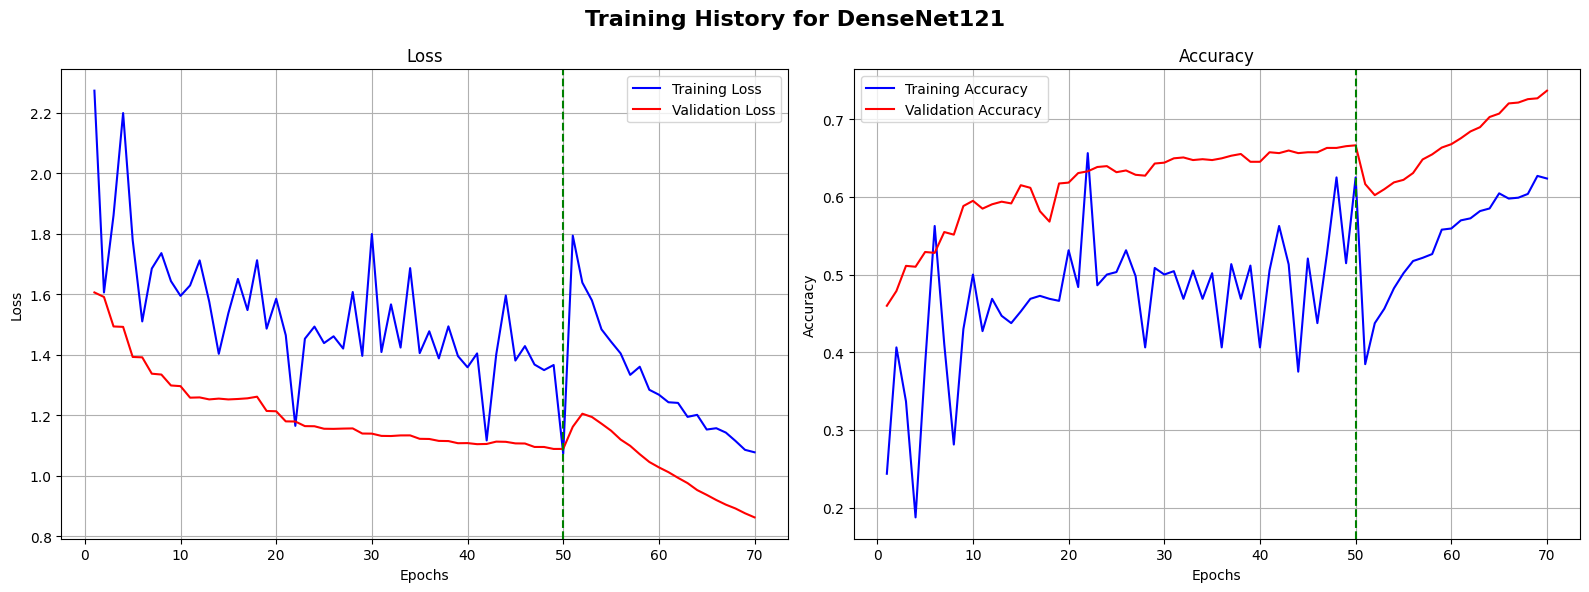

Saved training history for MobileNetV3 to: /content/drive/MyDrive/rose_project/visualizations/training_history_MobileNetV3.png


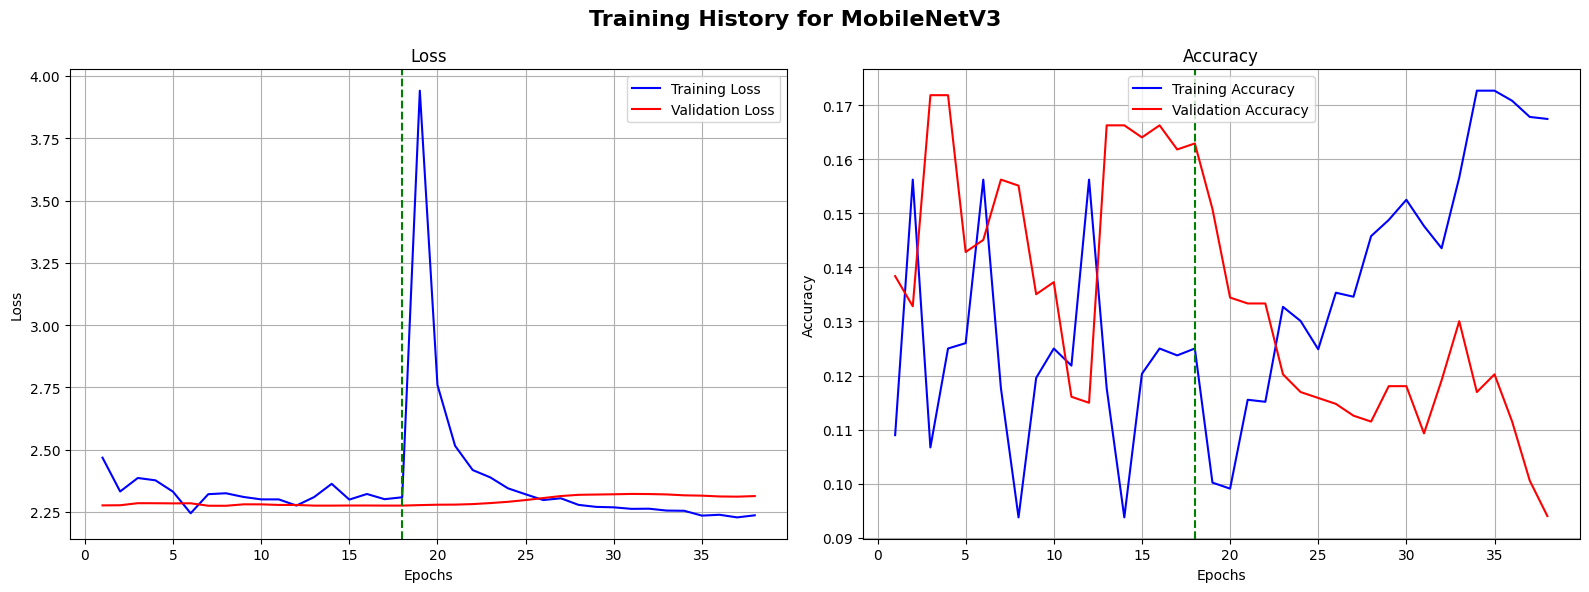


=== MODEL COMPARISON VISUALIZATION ===
Saved model comparison to: /content/drive/MyDrive/rose_project/visualizations/model_comparison.png


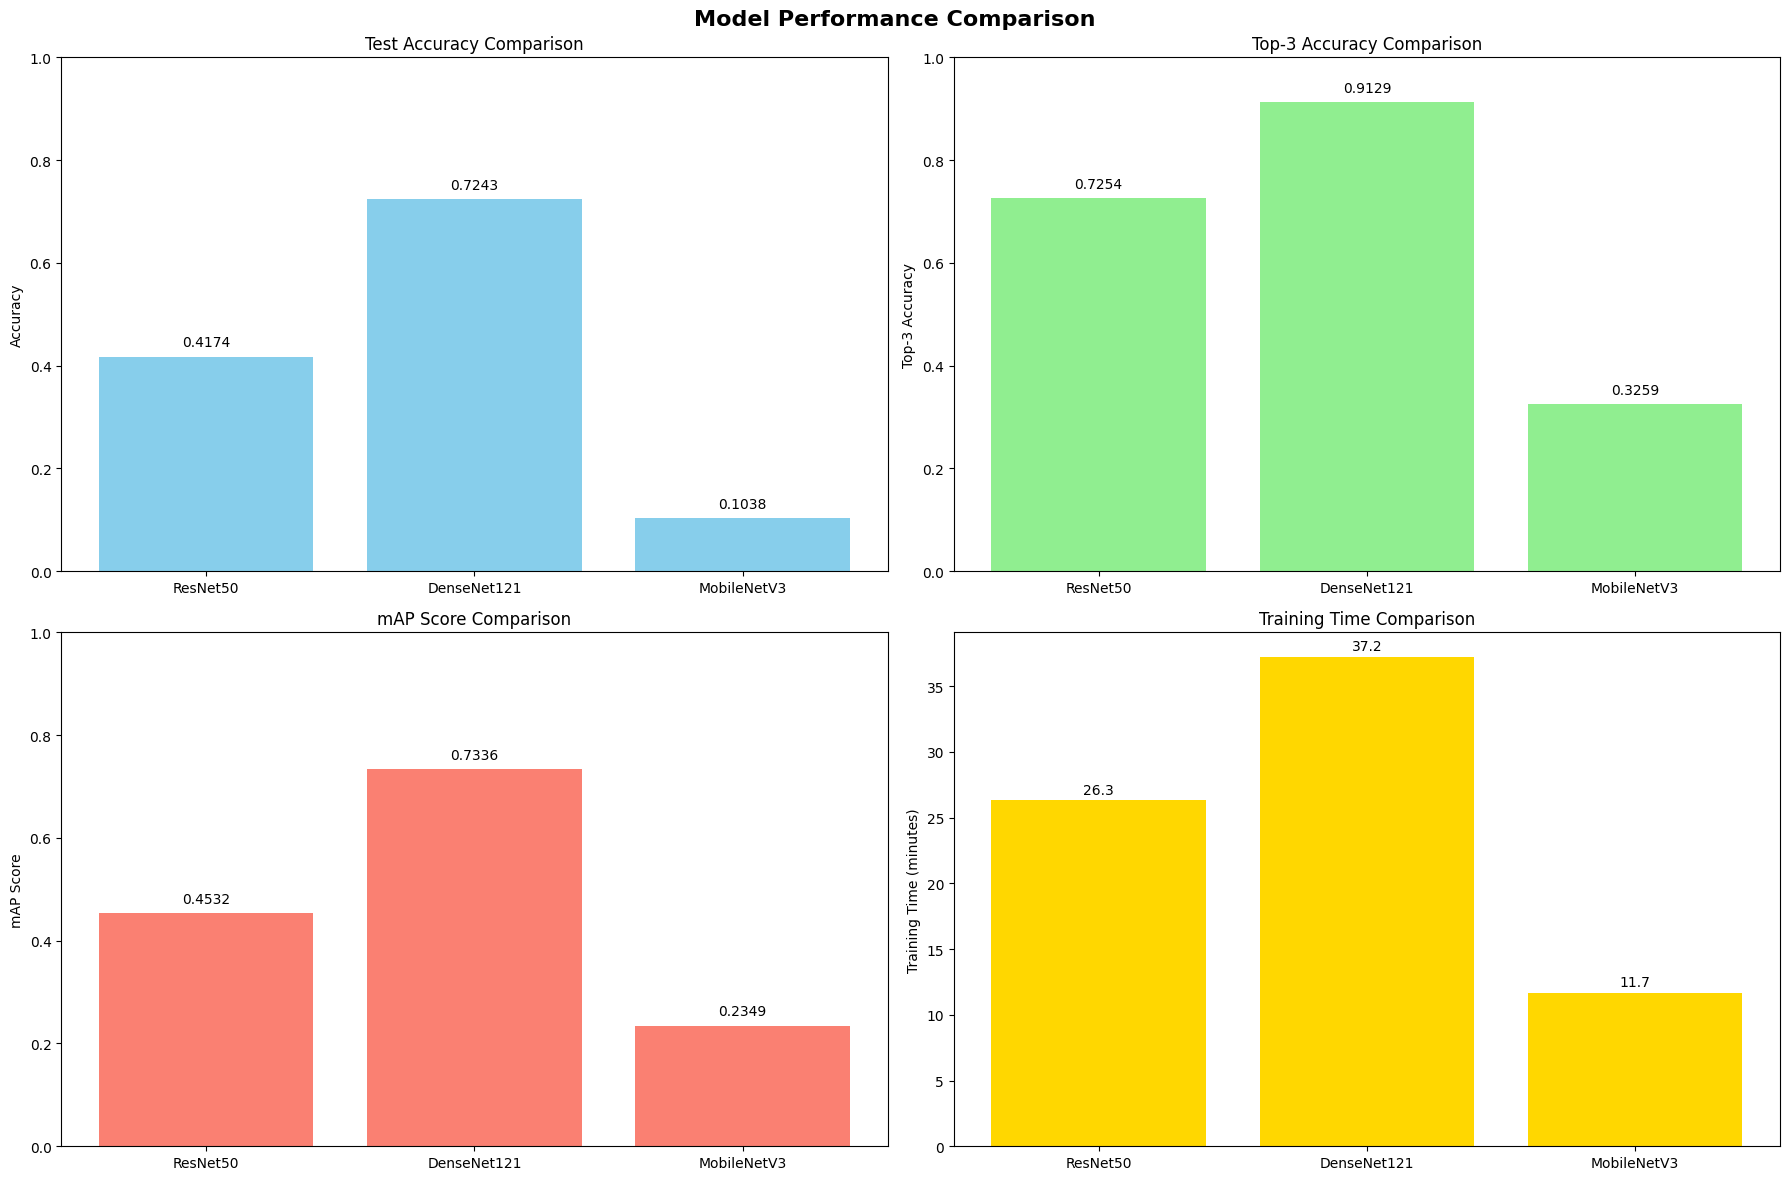


=== CONFUSION MATRIX VISUALIZATION ===
Found 918 images belonging to 10 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 290ms/step
Saved confusion matrix for ResNet50 to: /content/drive/MyDrive/rose_project/visualizations/confusion_matrix_ResNet50.png


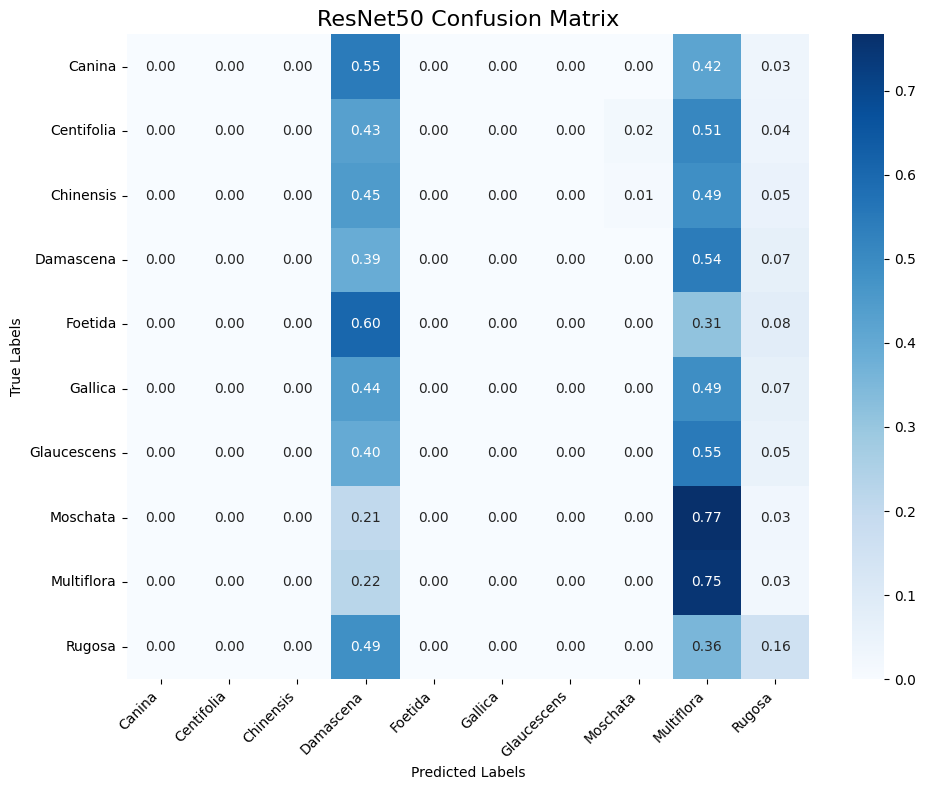

29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 476ms/step
Saved confusion matrix for DenseNet121 to: /content/drive/MyDrive/rose_project/visualizations/confusion_matrix_DenseNet121.png


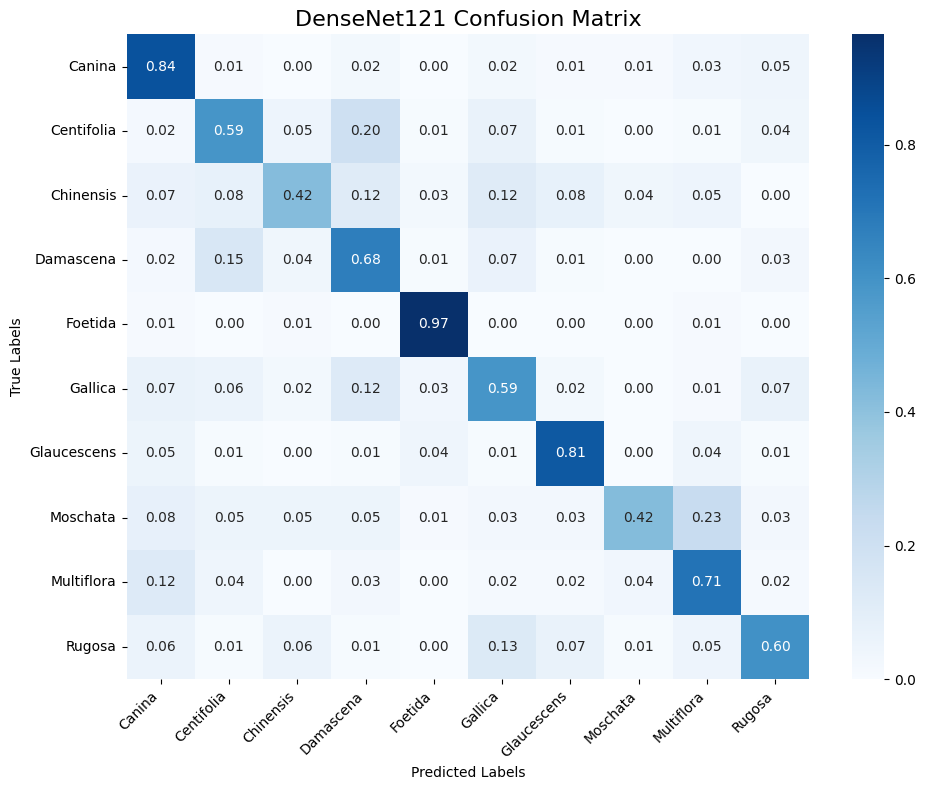

First load attempt failed for MobileNetV3: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)
Second load attempt failed for MobileNetV3: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)

=== PERFORMANCE ANALYSIS ===

Model Performance Summary:
      Model  Accuracy  Top-3 Accuracy  mAP Score  Parameters (M)  Training Time (min)  Accuracy/Params
   ResNet50    0.4174          0.7254     0.4532         24.6419              26.3316           0.0169
DenseNet121    0.7243          0.9129     0.7336          7.5674              37.2363           0.0957
MobileNetV3    0.1038          0.3259     0.2349          3.4935              11.6641           0.0297
Saved model performance summary to: /content/drive/MyDrive/rose_project/visualizations/model_performance_summary.csv
Saved model 

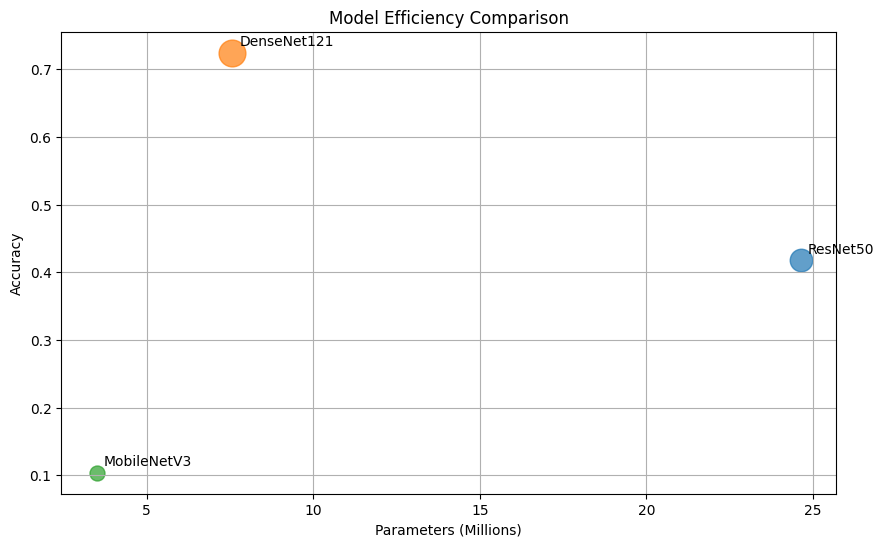


=== FINAL CONCLUSIONS AND RECOMMENDATIONS ===

Key Findings:
--------------------------------------------------
1. Best Performing Model: DenseNet121 with 72.43% accuracy
2. Most Efficient Model: DenseNet121 with accuracy-to-parameters ratio of 0.0957
3. Average Accuracy Across Models: 41.52%

Recommendations:
--------------------------------------------------
1. For highest accuracy: Use DenseNet121
2. For resource-constrained environments: Use DenseNet121
3. Consider ensemble methods combining top models for potential improvement
4. Additional data collection recommended for classes with lower representation
Saved conclusions to: /content/drive/MyDrive/rose_project/visualizations/conclusions.txt

Data Analyst tasks completed!
All visualizations and analysis reports saved to: /content/drive/MyDrive/rose_project/visualizations


In [2]:
# DATA ANALYST - Data Visualization and Analysis (Google Drive Version)
# Install required packages
!pip install matplotlib seaborn scikit-learn --quiet

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf  # Added import for custom objects
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

print("=== DATA ANALYST - VISUALIZATION AND ANALYSIS ===")

# Configuration - Set your Google Drive folder path here
GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/rose_project'
VISUALIZATION_DIR = os.path.join(GOOGLE_DRIVE_PATH, 'visualizations')
os.makedirs(VISUALIZATION_DIR, exist_ok=True)
print(f"Visualizations will be saved to: {VISUALIZATION_DIR}")

# Step 1: Load Training Results
print("\n=== LOADING TRAINING RESULTS ===")

# Define paths to results files
results_path = os.path.join(GOOGLE_DRIVE_PATH, 'results', 'training_results.json')
models_dir = os.path.join(GOOGLE_DRIVE_PATH, 'models')

try:
    with open(results_path, 'r') as f:
        models_info = json.load(f)
    print(f"Training results loaded successfully from: {results_path}")
except FileNotFoundError:
    print(f"Error: training_results.json not found at {results_path}")
    print("Please run the Data Scientist code first and ensure results are saved.")
    models_info = {}

# Step 2: Dataset Visualization
print("\n=== DATASET VISUALIZATION ===")

def visualize_dataset_distribution():
    """Visualize the distribution of rose subspecies in the dataset"""
    # Define all 10 rose subspecies classes
    rose_classes = [
        'rosa_rugosa', 'rosa_gallica', 'rosa_damascena', 'rosa_centifolia',
        'rosa_chinensis', 'rosa_canina', 'rosa_moschata', 'rosa_foetida',
        'rosa_multiflora', 'rosa_glaucescens'
    ]

    # Dataset path
    dataset_dir = os.path.join(GOOGLE_DRIVE_PATH, 'rose_dataset')

    # Count images in each class
    class_counts = {}
    for split in ['train', 'validation', 'test']:
        class_counts[split] = {}
        for class_name in rose_classes:
            class_dir = os.path.join(dataset_dir, split, class_name)
            if os.path.exists(class_dir):
                count = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
                class_counts[split][class_name] = count
            else:
                class_counts[split][class_name] = 0

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    fig.suptitle('Rose Subspecies Dataset Distribution (10 Classes)', fontsize=16, fontweight='bold')

    # Dataset split distribution
    splits = ['train', 'validation', 'test']
    split_totals = [sum(class_counts[split].values()) for split in splits]

    axes[0, 0].pie(split_totals, labels=splits, autopct='%1.1f%%', startangle=90,
                   colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0, 0].set_title('Dataset Split Distribution')

    # Class distribution in training set
    train_counts = list(class_counts['train'].values())
    class_labels = [name.replace('rosa_', '').replace('_', ' ').title() for name in rose_classes]

    axes[0, 1].barh(class_labels, train_counts,
                   color=sns.color_palette("husl", len(rose_classes)))
    axes[0, 1].set_title('Training Set Class Distribution')
    axes[0, 1].set_xlabel('Number of Images')
    axes[0, 1].set_ylabel('Rose Subspecies')

    # Stacked bar chart for all splits
    df_counts = pd.DataFrame(class_counts).T
    df_counts.plot(kind='barh', stacked=True, ax=axes[1, 0],
                  colormap='viridis')
    axes[1, 0].set_title('Images per Class Across All Splits')
    axes[1, 0].set_xlabel('Number of Images')
    axes[1, 0].set_ylabel('Dataset Split')
    axes[1, 0].legend(title='Rose Subspecies', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Heatmap of class distribution
    sns.heatmap(pd.DataFrame(class_counts).T, annot=True, fmt='d',
               cmap='YlGnBu', ax=axes[1, 1])
    axes[1, 1].set_title('Class Distribution Heatmap')
    axes[1, 1].set_xlabel('Dataset Split')
    axes[1, 1].set_ylabel('Rose Subspecies')

    plt.tight_layout()

    # Save visualization
    file_path = os.path.join(VISUALIZATION_DIR, 'dataset_distribution.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Saved dataset visualization to: {file_path}")
    plt.show()

    return class_counts

# Generate dataset visualization
dataset_stats = visualize_dataset_distribution()

# Step 3: Training Performance Visualization (Updated)
print("\n=== TRAINING PERFORMANCE VISUALIZATION ===")

def plot_training_history():
    """Plot training and validation loss/accuracy for each model separately"""
    if not models_info:
        print("No training results available to plot.")
        return

    # Create separate plots for each model
    for model_name, info in models_info.items():
        history = info['history']
        fine_tune_history = info.get('fine_tune_history', {})

        # Combine initial training and fine-tuning history if available
        if fine_tune_history:
            # Combine losses
            full_loss = history['loss'] + fine_tune_history['loss']
            full_val_loss = history['val_loss'] + fine_tune_history['val_loss']
            full_accuracy = history['accuracy'] + fine_tune_history['accuracy']
            full_val_accuracy = history['val_accuracy'] + fine_tune_history['val_accuracy']
            epochs = range(1, len(full_loss) + 1)

            # Create combined figure for loss and accuracy
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'Training History for {model_name}', fontsize=16, fontweight='bold')

            # Plot Loss
            ax1.plot(epochs, full_loss, 'b-', label='Training Loss')
            ax1.plot(epochs, full_val_loss, 'r-', label='Validation Loss')
            ax1.set_title('Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True)

            # Mark fine-tuning start
            ax1.axvline(x=len(history['loss']), color='g', linestyle='--',
                       label='Fine-tuning Start')

            # Plot Accuracy
            ax2.plot(epochs, full_accuracy, 'b-', label='Training Accuracy')
            ax2.plot(epochs, full_val_accuracy, 'r-', label='Validation Accuracy')
            ax2.set_title('Accuracy')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            ax2.grid(True)

            # Mark fine-tuning start
            ax2.axvline(x=len(history['accuracy']), color='g', linestyle='--',
                       label='Fine-tuning Start')
        else:
            # Only initial training history
            epochs = range(1, len(history['loss']) + 1)

            # Create figure for loss and accuracy
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'Training History for {model_name}', fontsize=16, fontweight='bold')

            # Plot Loss
            ax1.plot(epochs, history['loss'], 'b-', label='Training Loss')
            ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
            ax1.set_title('Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True)

            # Plot Accuracy
            ax2.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
            ax2.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
            ax2.set_title('Accuracy')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            ax2.grid(True)

        plt.tight_layout()

        # Save visualization
        file_path = os.path.join(VISUALIZATION_DIR, f'training_history_{model_name}.png')
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        print(f"Saved training history for {model_name} to: {file_path}")
        plt.show()

# Generate training performance plots
plot_training_history()

# Step 4: Model Comparison Visualization (Updated)
print("\n=== MODEL COMPARISON VISUALIZATION ===")

def create_model_comparison():
    """Create comprehensive model comparison visualizations"""
    if not models_info:
        print("No models to compare.")
        return None

    # Extract metrics for comparison
    models = list(models_info.keys())
    metrics = {
        'Accuracy': [models_info[model]['evaluation']['test_accuracy'] for model in models],
        'Top-3 Accuracy': [models_info[model]['evaluation']['test_top3_accuracy'] for model in models],
        'mAP Score': [models_info[model]['evaluation']['map_score'] for model in models],
        'Parameters (M)': [models_info[model]['evaluation']['model_params']/1e6 for model in models],
        'Training Time (min)': [models_info[model]['training_time']/60 for model in models]
    }

    # Create separate bar charts for each metric
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    # Accuracy comparison
    axes[0, 0].bar(models, metrics['Accuracy'], color='skyblue')
    axes[0, 0].set_title('Test Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1.0)
    for i, v in enumerate(metrics['Accuracy']):
        axes[0, 0].text(i, v + 0.02, f"{v:.4f}", ha='center')

    # Top-3 Accuracy comparison
    axes[0, 1].bar(models, metrics['Top-3 Accuracy'], color='lightgreen')
    axes[0, 1].set_title('Top-3 Accuracy Comparison')
    axes[0, 1].set_ylabel('Top-3 Accuracy')
    axes[0, 1].set_ylim(0, 1.0)
    for i, v in enumerate(metrics['Top-3 Accuracy']):
        axes[0, 1].text(i, v + 0.02, f"{v:.4f}", ha='center')

    # mAP Score comparison
    axes[1, 0].bar(models, metrics['mAP Score'], color='salmon')
    axes[1, 0].set_title('mAP Score Comparison')
    axes[1, 0].set_ylabel('mAP Score')
    axes[1, 0].set_ylim(0, 1.0)
    for i, v in enumerate(metrics['mAP Score']):
        axes[1, 0].text(i, v + 0.02, f"{v:.4f}", ha='center')

    # Training Time comparison
    axes[1, 1].bar(models, metrics['Training Time (min)'], color='gold')
    axes[1, 1].set_title('Training Time Comparison')
    axes[1, 1].set_ylabel('Training Time (minutes)')
    for i, v in enumerate(metrics['Training Time (min)']):
        axes[1, 1].text(i, v + 0.5, f"{v:.1f}", ha='center')

    plt.tight_layout()

    # Save visualization
    file_path = os.path.join(VISUALIZATION_DIR, 'model_comparison.png')
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    print(f"Saved model comparison to: {file_path}")
    plt.show()

    return metrics

# Generate model comparison
comparison_metrics = create_model_comparison()

# Step 5: Confusion Matrix Visualization (Fixed)
print("\n=== CONFUSION MATRIX VISUALIZATION ===")

def create_confusion_matrices():
    """Create confusion matrices for all models separately with robust loading"""
    if not models_info:
        print("No models available for confusion matrices.")
        return

    # Load test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_dir = os.path.join(GOOGLE_DRIVE_PATH, 'rose_dataset', 'test')
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Handle case with no classes found
    if not hasattr(test_generator, 'class_indices') or not test_generator.class_indices:
        print(f"Error: No classes found in test directory: {test_dir}")
        return

    class_names = [name.replace('rosa_', '').replace('_', ' ').title()
                  for name in sorted(test_generator.class_indices.keys())]

    # Create separate confusion matrix for each model
    for model_name in models_info.keys():
        try:
            # Robust model loading for MobileNetV3
            model_path = os.path.join(models_dir, model_name, f'{model_name}_best.h5')
            if not os.path.exists(model_path):
                print(f"Model not found: {model_path}")
                continue

            # Define custom activation functions
            def hard_swish(x):
                return x * tf.nn.relu6(x + 3) / 6

            def hard_sigmoid(x):
                return tf.nn.relu6(x + 3) / 6

            # Create comprehensive custom objects
            custom_objects = {
                'hard_swish': hard_swish,
                'hard_sigmoid': hard_sigmoid,
                'HardSwish': hard_swish,
                'HardSigmoid': hard_sigmoid,
                'relu6': tf.nn.relu6,
                'swish': tf.nn.swish,
                'leaky_relu': tf.nn.leaky_relu
            }

            # Try loading with custom objects
            try:
                model = load_model(model_path, custom_objects=custom_objects, compile=False)
            except Exception as e:
                print(f"First load attempt failed for {model_name}: {e}")
                # Try alternative loading method
                try:
                    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)
                except Exception as e2:
                    print(f"Second load attempt failed for {model_name}: {e2}")
                    continue

            # Generate predictions
            y_pred = model.predict(test_generator)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true = test_generator.classes

            # Create confusion matrix
            cm = confusion_matrix(y_true, y_pred_classes)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # Create figure
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names)
            plt.title(f'{model_name} Confusion Matrix', fontsize=16)
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()

            # Save visualization
            file_path = os.path.join(VISUALIZATION_DIR, f'confusion_matrix_{model_name}.png')
            plt.savefig(file_path, dpi=300, bbox_inches='tight')
            print(f"Saved confusion matrix for {model_name} to: {file_path}")
            plt.show()

        except Exception as e:
            print(f"Error generating confusion matrix for {model_name}: {e}")

# Generate confusion matrices
create_confusion_matrices()

# Step 6: Performance Analysis and Insights
print("\n=== PERFORMANCE ANALYSIS ===")

def analyze_model_performance():
    """Analyze and compare model performance"""
    if not models_info:
        print("No training results found.")
        return None

    analysis_data = []
    for model_name, info in models_info.items():
        eval_data = info['evaluation']
        analysis_data.append({
            'Model': model_name,
            'Accuracy': eval_data['test_accuracy'],
            'Top-3 Accuracy': eval_data['test_top3_accuracy'],
            'mAP Score': eval_data['map_score'],
            'Parameters (M)': eval_data['model_params'] / 1e6,
            'Training Time (min)': info['training_time'] / 60,
            'Accuracy/Params': eval_data['test_accuracy'] / (eval_data['model_params'] / 1e6)
        })

    df = pd.DataFrame(analysis_data)

    # Display analysis
    print("\nModel Performance Summary:")
    print("="*80)
    print(df.to_string(float_format='%.4f', index=False))

    # Save summary to CSV
    csv_path = os.path.join(VISUALIZATION_DIR, 'model_performance_summary.csv')
    df.to_csv(csv_path, index=False)
    print(f"Saved model performance summary to: {csv_path}")

    # Create efficiency comparison chart
    plt.figure(figsize=(10, 6))
    for i, row in df.iterrows():
        plt.scatter(row['Parameters (M)'], row['Accuracy'],
                   s=row['Training Time (min)']*10,
                   label=row['Model'], alpha=0.7)
        plt.annotate(row['Model'], (row['Parameters (M)'], row['Accuracy']),
                     xytext=(5, 5), textcoords='offset points')

    plt.xlabel('Parameters (Millions)')
    plt.ylabel('Accuracy')
    plt.title('Model Efficiency Comparison')
    plt.grid(True)

    # Save visualization
    file_path = os.path.join(VISUALIZATION_DIR, "model_efficiency.png")
    plt.savefig(file_path, dpi=300)
    print(f"Saved model efficiency plot to: {file_path}")
    plt.show()

    return df

# Perform analysis
performance_df = analyze_model_performance()

# Step 7: Final Conclusions and Recommendations
print("\n=== FINAL CONCLUSIONS AND RECOMMENDATIONS ===")

def generate_conclusions():
    """Generate final conclusions and recommendations"""
    if performance_df is None:
        print("No performance data available.")
        return

    best_model = performance_df.loc[performance_df['Accuracy'].idxmax()]
    most_efficient = performance_df.loc[performance_df['Accuracy/Params'].idxmax()]

    print("\nKey Findings:")
    print("-"*50)
    print(f"1. Best Performing Model: {best_model['Model']} with {best_model['Accuracy']:.2%} accuracy")
    print(f"2. Most Efficient Model: {most_efficient['Model']} with accuracy-to-parameters ratio of {most_efficient['Accuracy/Params']:.4f}")
    print(f"3. Average Accuracy Across Models: {performance_df['Accuracy'].mean():.2%}")

    print("\nRecommendations:")
    print("-"*50)
    print("1. For highest accuracy: Use", best_model['Model'])
    print("2. For resource-constrained environments: Use", most_efficient['Model'])
    print("3. Consider ensemble methods combining top models for potential improvement")
    print("4. Additional data collection recommended for classes with lower representation")

    # Save conclusions to file
    conclusions_path = os.path.join(VISUALIZATION_DIR, 'conclusions.txt')
    with open(conclusions_path, 'w') as f:
        f.write("Final Conclusions and Recommendations\n")
        f.write("="*50 + "\n\n")
        f.write("Key Findings:\n")
        f.write("-"*50 + "\n")
        f.write(f"1. Best Performing Model: {best_model['Model']} with {best_model['Accuracy']:.2%} accuracy\n")
        f.write(f"2. Most Efficient Model: {most_efficient['Model']} with accuracy-to-parameters ratio of {most_efficient['Accuracy/Params']:.4f}\n")
        f.write(f"3. Average Accuracy Across Models: {performance_df['Accuracy'].mean():.2%}\n\n")

        f.write("Recommendations:\n")
        f.write("-"*50 + "\n")
        f.write("1. For highest accuracy: Use " + best_model['Model'] + "\n")
        f.write("2. For resource-constrained environments: Use " + most_efficient['Model'] + "\n")
        f.write("3. Consider ensemble methods combining top models for potential improvement\n")
        f.write("4. Additional data collection recommended for classes with lower representation\n\n")

        f.write("Next Steps:\n")
        f.write("- Hyperparameter tuning for selected model\n")
        f.write("- Data augmentation for minority classes\n")
        f.write("- Model deployment with monitoring\n")

    print(f"Saved conclusions to: {conclusions_path}")

# Generate conclusions
generate_conclusions()

print("\nData Analyst tasks completed!")
print(f"All visualizations and analysis reports saved to: {VISUALIZATION_DIR}")